In [1]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch
import numpy as np
import cv2
from samples.CLS2IDX import CLS2IDX

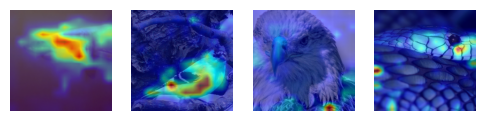

In [2]:
# define model, dataset 
from baselines.ViT.ViT_LRP import vit_base_patch16_224 as vit_LRP
from baselines.ViT.ViT_explanation_generator import LRP
import torchvision.transforms as T
import torchvision 
from dataset import IMAGENET_STD, IMAGENET_MEAN, denormalize

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return cam


def post_process_attribution(transformer_attribution):
    transformer_attribution = transformer_attribution.detach().cpu() 
    if transformer_attribution.shape[-1] ==196:
        transformer_attribution = transformer_attribution.reshape(1, 1, 14, 14)
        transformer_attribution = torch.nn.functional.interpolate(transformer_attribution, scale_factor=16, mode='bilinear')
    transformer_attribution = transformer_attribution.reshape(224, 224).cuda().data.cpu().numpy()
    transformer_attribution = (transformer_attribution - transformer_attribution.min()) / (transformer_attribution.max() - transformer_attribution.min())
    return transformer_attribution

data_path = '/data/ImageNet1k'

transform = T.Compose([
                T.Resize(256),
                T.CenterCrop(224),
                T.ToTensor(), 
                T.Normalize(IMAGENET_MEAN, IMAGENET_STD)
            ])

valid_dataset = torchvision.datasets.ImageNet(root=data_path, split="val", transform=transform)

# initialize ViT pretrained
model = vit_LRP(pretrained=True).cuda()
model.eval()
attribution_generator = LRP(model)


random_indices = [123, 567, 1111, 3234]
fig, axes = plt.subplots(1,len(random_indices), figsize=(len(random_indices)*1.5, 1.5))
axes = axes.flat 

for idx in random_indices:
    ax = next(axes)
    original_image, class_index = valid_dataset[idx]
    transformer_attribution = attribution_generator.generate_LRP(original_image.unsqueeze(0).cuda(), method="transformer_attribution", index=class_index)
    transformer_attribution = post_process_attribution(transformer_attribution)

    original_image = denormalize(original_image)
    original_image = original_image.permute(1,2,0)

    vis = show_cam_on_image(original_image, transformer_attribution)
    vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)

    ax.imshow(vis)
    ax.axis("off")

In [3]:
from tqdm import tqdm 
methods = ['transformer_attribution', 'rollout', 'full', 'last_layer', 'last_layer_attn', 'second_layer', ]

attrs = np.zeros(shape=(len(methods), len(valid_dataset), 224,224)).astype(np.float16)
pbar = tqdm(range(len(valid_dataset)))
for idx in pbar:
    original_image, class_index = valid_dataset[idx]
    original_image = original_image.unsqueeze(0).cuda()
    for midx, method in enumerate(methods): 
        transformer_attribution = attribution_generator.generate_LRP(original_image, method=method, index=class_index)
        transformer_attribution = post_process_attribution(transformer_attribution)
        attrs[midx, idx] = transformer_attribution.astype(np.float16)

  1%|          | 275/50000 [04:57<15:11:49,  1.10s/it]